# Setup

In [1]:
import tensorflow as tf
import os 
import zipfile
import numpy as np
import matplotlib.pyplot as plt

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!kaggle competitions download -c dogs-vs-cats

 98% 794M/812M [00:05<00:00, 148MB/s]
100% 812M/812M [00:05<00:00, 151MB/s]


Organise dataset

In [3]:
zip_ref = zipfile.ZipFile('dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')

zip_ref = zipfile.ZipFile('train.zip', 'r')
zip_ref.extractall('/content/')
zip_ref = zipfile.ZipFile('test1.zip', 'r')
zip_ref.extractall('/content/data/testing/')
zip_ref.close()

In [6]:
os.makedirs("/content/data/training/cat")
os.makedirs("/content/data/training/dog")

In [7]:
# Check number of files
len(os.listdir('/content/train/'))

25000

Split Cat/Dog into sub directories for training

In [8]:
for f in os.listdir("/content/train/"):
  currentPath = "/content/train/"
  newPath = "/content/data/training/"
  if f.startswith("cat"):
    os.rename(f"{currentPath}{f}", f"{newPath}cat/{f}")
  elif f.startswith("dog"):
    os.rename(f"{currentPath}{f}", f"{newPath}dog/{f}")

Set Random Seed for Comparing Metrics

In [ ]:
#tf.random.set_seed(0)
#np.random.seed(0)

# Data Preprocessing

In [9]:
train = tf.keras.utils.image_dataset_from_directory("/content/data/training/", batch_size=64)
test = tf.keras.utils.image_dataset_from_directory("/content/data/testing/", batch_size=64)

Found 25000 files belonging to 2 classes.
Found 12500 files belonging to 1 classes.


In [10]:
train_it = train.as_numpy_iterator()
train_batch = train_it.next()

train = train.map(lambda x,y: (x/255, y))

In [ ]:
# Try to look for the gray channel (reduce learning time)



In [11]:
test_it = test.as_numpy_iterator()
test_batch = test_it.next()

test = test.map(lambda x,y: (x/255, y))

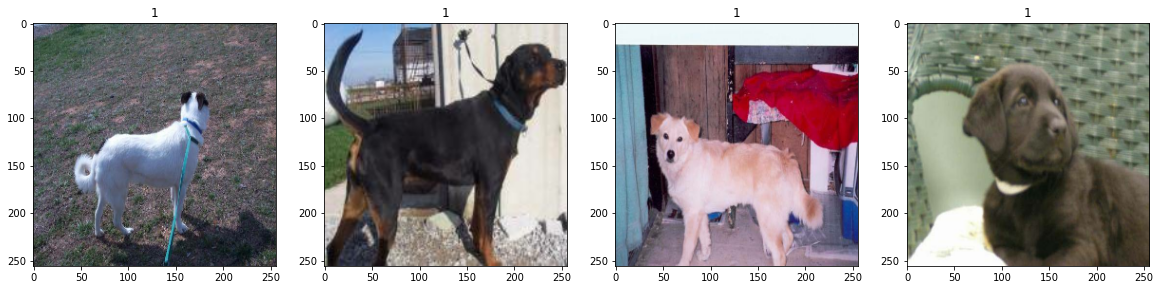

In [12]:
# Check classifier flags
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(train_batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(train_batch[1][idx])

## 0 = Cat; 1 = Dog

Split training and validation data

In [13]:
train_size = int(len(train)*.02)
val_size = int(len(test)*.03)

train_snip = train.take(train_size)
val_snip = test.take(val_size)

In [14]:
# Take smaller sample
test_size = int(len(test)*.05)
test_snip = test.take(test_size)

In [15]:
# Number of batches: Check
print(f"Train size: {len(train_snip)}")
print(f"Valid size: {len(val_snip)}")
print(f"Test  size: {len(test_snip)}")

Train size: 7
Valid size: 5
Test  size: 9


# Build Model

In [38]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.metrics import Accuracy

model = tf.keras.models.Sequential()

# Input layer, 16 3x3 filters, stride of 1
## input_shape -> image data_from_directory reshapes to 256,256,3(channels)
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [39]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=Accuracy())

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# Train

In [19]:
from datetime import datetime

# Clear out prior logging data.
#!rm -rf logs/

# Can check training steps in logs
logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)


*NOTE: The validation_data arg sometimes causes issues with the funtion getting hung up on the end of an epoch. I can see the error handler is being called, sometimes it resolves, sometimes not. 
Similar [issue on Github](https://github.com/tensorflow/tensorflow/issues/36287) suggest this is a problem with how the validation data was generated.*

In [31]:
hist = model.fit(train_snip, epochs=10, validation_data=val_snip, callbacks=[tensorboard_callback])

Epoch 1/10
7/7 [==============================] - 39s 6s/step - loss: 1.0280 - binary_accuracy: 0.4911 - precision_1: 0.4937 - recall_1: 0.7009 - val_loss: 0.6019 - val_binary_accuracy: 1.0000 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/10
7/7 [==============================] - 38s 5s/step - loss: 0.6913 - binary_accuracy: 0.5357 - precision_1: 0.5694 - recall_1: 0.5168 - val_loss: 0.8302 - val_binary_accuracy: 0.0031 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/10
7/7 [==============================] - 38s 6s/step - loss: 0.6822 - binary_accuracy: 0.5848 - precision_1: 0.5633 - recall_1: 0.9277 - val_loss: 0.7365 - val_binary_accuracy: 0.1281 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/10
7/7 [==============================] - 38s 6s/step - loss: 0.6779 - binary_accuracy: 0.5871 - precision_1: 0.5641 - recall_1: 0.7822 - val_loss: 0.7436 - val_binary_accuracy: 0.2125 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00


# Plots & Logs

In [ ]:
# Start Tensorboard
#%load_ext tensorboard
#%tensorboard --logdir logs/

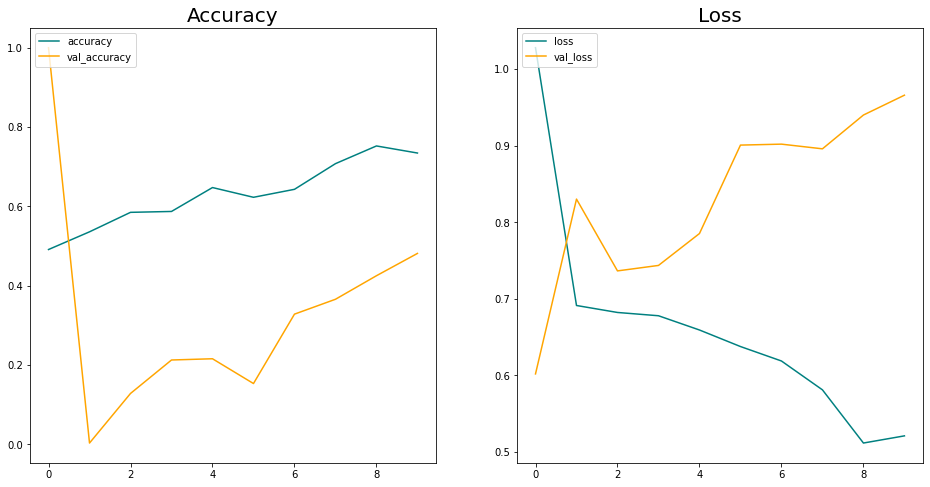

In [34]:
fig = plt.figure(figsize=(16, 8))
fig.add_subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('Accuracy', fontsize=20)
plt.legend(loc="upper left")
fig.add_subplot(1, 2, 2)
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.title('Loss', fontsize=20)
plt.legend(loc="upper left")

plt.show()

# Evaluate Test Data

In [35]:
eval = model.evaluate(test_snip)
results = dict(zip(model.metrics_names, eval))

print(results)

9/9 [==============================] - 11s 1s/step - loss: 1.0196 - binary_accuracy: 0.4392 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
{'loss': 1.0195910930633545, 'binary_accuracy': 0.4392361044883728, 'precision_1': 0.0, 'recall_1': 0.0}


# Test Single Image

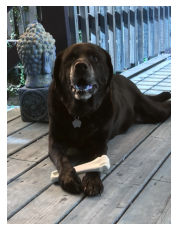

In [40]:
import cv2

im = cv2.imread('mikey.jpeg')
plt.axis('off')
plt.imshow(im)
plt.show()

In [41]:
#resize for model
resize = tf.image.resize(im, (256,256)) 

yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat)
if yhat > 0.5: 
    print(f'Predicted class is Dog')
else:
    print(f'Predicted class is Cat')

1/1 [==============================] - 0s 104ms/step
[[0.430185]]
Predicted class is Cat


Reshape image for feature map visualisation

In [42]:
image = im.reshape((1,) + im.shape)
image = tf.image.resize(image, (256,256))
image /= 255.0

List layers and feature map shapes

Source: [Renu Khandelwal](https://towardsdatascience.com/convolutional-neural-network-feature-map-and-filter-visualization-f75012a5a49c)

In [43]:
layer_names = [layer.name for layer in model.layers]
layer_outputs = [layer.output for layer in model.layers[1:]]
feature_map_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
feature_maps = feature_map_model.predict(image)

for layer_name, feature_map in zip(layer_names, feature_maps):print(f"The shape of the {layer_name} is =======>> {feature_map.shape}")


1/1 [==============================] - 0s 99ms/step
The shape of the conv2d_9 is =======>> (1, 127, 127, 16)
The shape of the max_pooling2d_9 is =======>> (1, 125, 125, 32)
The shape of the conv2d_10 is =======>> (1, 62, 62, 32)
The shape of the max_pooling2d_10 is =======>> (1, 60, 60, 16)
The shape of the conv2d_11 is =======>> (1, 30, 30, 16)
The shape of the max_pooling2d_11 is =======>> (1, 14400)
The shape of the flatten_3 is =======>> (1, 256)
The shape of the dense_6 is =======>> (1, 1)


Generate feature map

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


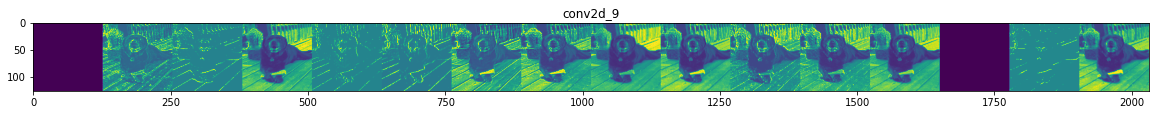

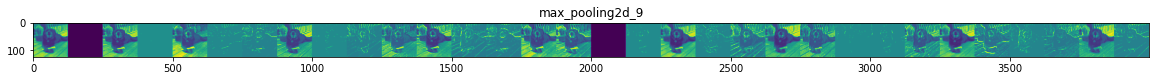

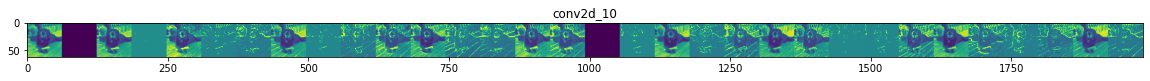

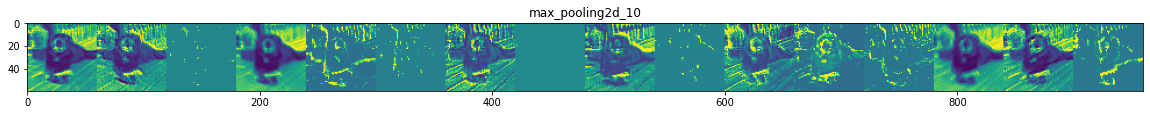

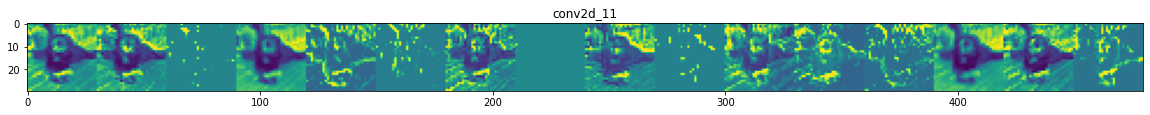

In [44]:
for layer_name, feature_map in zip(layer_names, feature_maps):  
  if len(feature_map.shape) == 4:
    n_features = feature_map.shape[-1]  # num features
    size = feature_map.shape[1] # feature map shape
    display_grid = np.zeros((size, size * n_features))

    # separate feature images, plot
    for i in range(n_features):
      feature_image = feature_map[0, :, :, i]
      # standardise, normalise
      feature_image -= feature_image.mean()
      feature_image /= feature_image.std()
      feature_image *=  64
      feature_image += 128
      feature_image = np.clip(feature_image, 0, 255).astype('uint8')
      # display on grid
      display_grid[:, i * size : (i + 1) * size] = feature_image

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto' ) 